# Using Unsupervised Learning & Network Analysis to Identify Yelp's Most Trendy & Influential Users

---
**The goal of this project is to identify the most 'trendy' & influential reviewers on Yelp. The data was taken from Yelp's 9th Annual Data Challenge, which originally included over +500k businesses, +1 million users, & +4 million reviews.**

A large amount of time was spent filtering, cleaning, & performing EDA on the code, both in PostgreSQL & Python. For the sake of making the logic simple to follow, I have decided to exclude it. In this notebook, I analyze specifically in the city of Cleveland, which has **3,838 businesses.**

---
## Import Relevant Packages

In [18]:
from IPython.display import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as lab
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import math
from dtaidistance import dtw

%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load Cleveland_Businesses CSV as DataFrame

In [19]:
cleveland_businesses = pd.read_csv("/Users/DanielCervoni/Documents/Data_Science/Yelp_Capstone_Work/yelp_dataset_challenge_round9/Yelp_Cleaned_Datasets/cleveland_businesses.csv")

In [20]:
cleveland_businesses.head()

,business_id,name,state,city,year,month,review_count,categories
0,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2014,11,2,"[u'Restaurants', u'Nightlife', u'Sports Bars',..."
1,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2014,12,2,"[u'Restaurants', u'Nightlife', u'Sports Bars',..."
2,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2015,1,3,"[u'Restaurants', u'Nightlife', u'Sports Bars',..."
3,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2015,2,2,"[u'Restaurants', u'Nightlife', u'Sports Bars',..."
4,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2015,3,1,"[u'Restaurants', u'Nightlife', u'Sports Bars',..."


Our dataframe has 8 columns: **business_id, name, state, city, year, month, review_count, & categories.** We will mainly be working with the business_id, year, month, & review_count columns.

---
## Plot Time Series & Dynamic-Time-Warping

One way to approach classifying businesses as trendy or not trendy is by using time-series analysis. Specifically, we can calculate the distance (similarity) measures between each of the time-series in our dataset and then cluster them together with unsupervised learning. 

However, basic distance formulas won't work in this case, because our time-series are of different lengths. Therefore, we'll have to use a **dynamic-time-warping algorithm to normalize for the difference in length between our time series.**

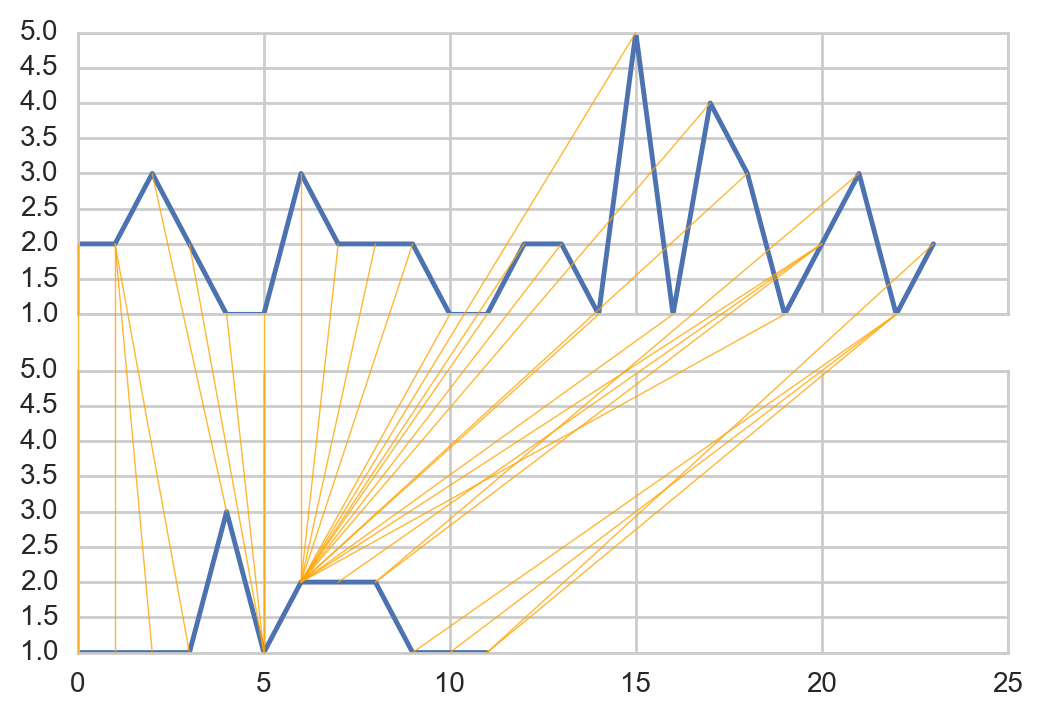

In [21]:
#dynamic-time-warping illustration
Image(filename = "/Users/DanielCervoni/Desktop/dtw-plotting.png")

## Dynamic Time Warping & Distance Matrix

In [22]:
def dynamic_time_warp(df, review_column):
    #prepare data for dynamic time warping
    review_count_lst = []

    #append arrays of reviews from df to list
    for bid in df.business_id.unique():
        bid_one = df[df.business_id == bid]
        rev_count_lst = bid_one[review_column].tolist()
        rev_count_lst = np.asarray(rev_count_lst, dtype = np.double)
        review_count_lst.append(rev_count_lst)

    #calculate dynamic time warping distance matrix
    dm = dtw.distance_matrix_fast(review_count_lst, max_dist = None, window = None, max_length_diff= None, show_progress= True)

    #remove infinity values from matrix
    dm_new = np.minimum(dm, dm.T)

    #replace infinity values in diagonal with 0
    np.fill_diagonal(dm_new, 0)
    
    return dm_new

In [23]:
review_count_dtw = dynamic_time_warp(cleveland_businesses, 'review_count')

Our dynamic-time-warping algorithm returns a **distance matrix of 3,838 x 3,838.** Now that we have the distances between each of our businesses, we are ready to apply unsupervised clustering to get a better understanding of the number of 'different time-series types' in our dataset.

---
## Applying Agglomerative Hierarchical Clustering

Below we apply **agglomerative hierarchical clustering** to our distance matrix in order to identify the number of clusters in our dataset and plot a dendrogram to identify these clusters. Agglomerative clustering is a better choice here than k-means given that I don't want to prespecify the number of clusters. K-means also returns different clusters each time its ran, which is also not ideal.

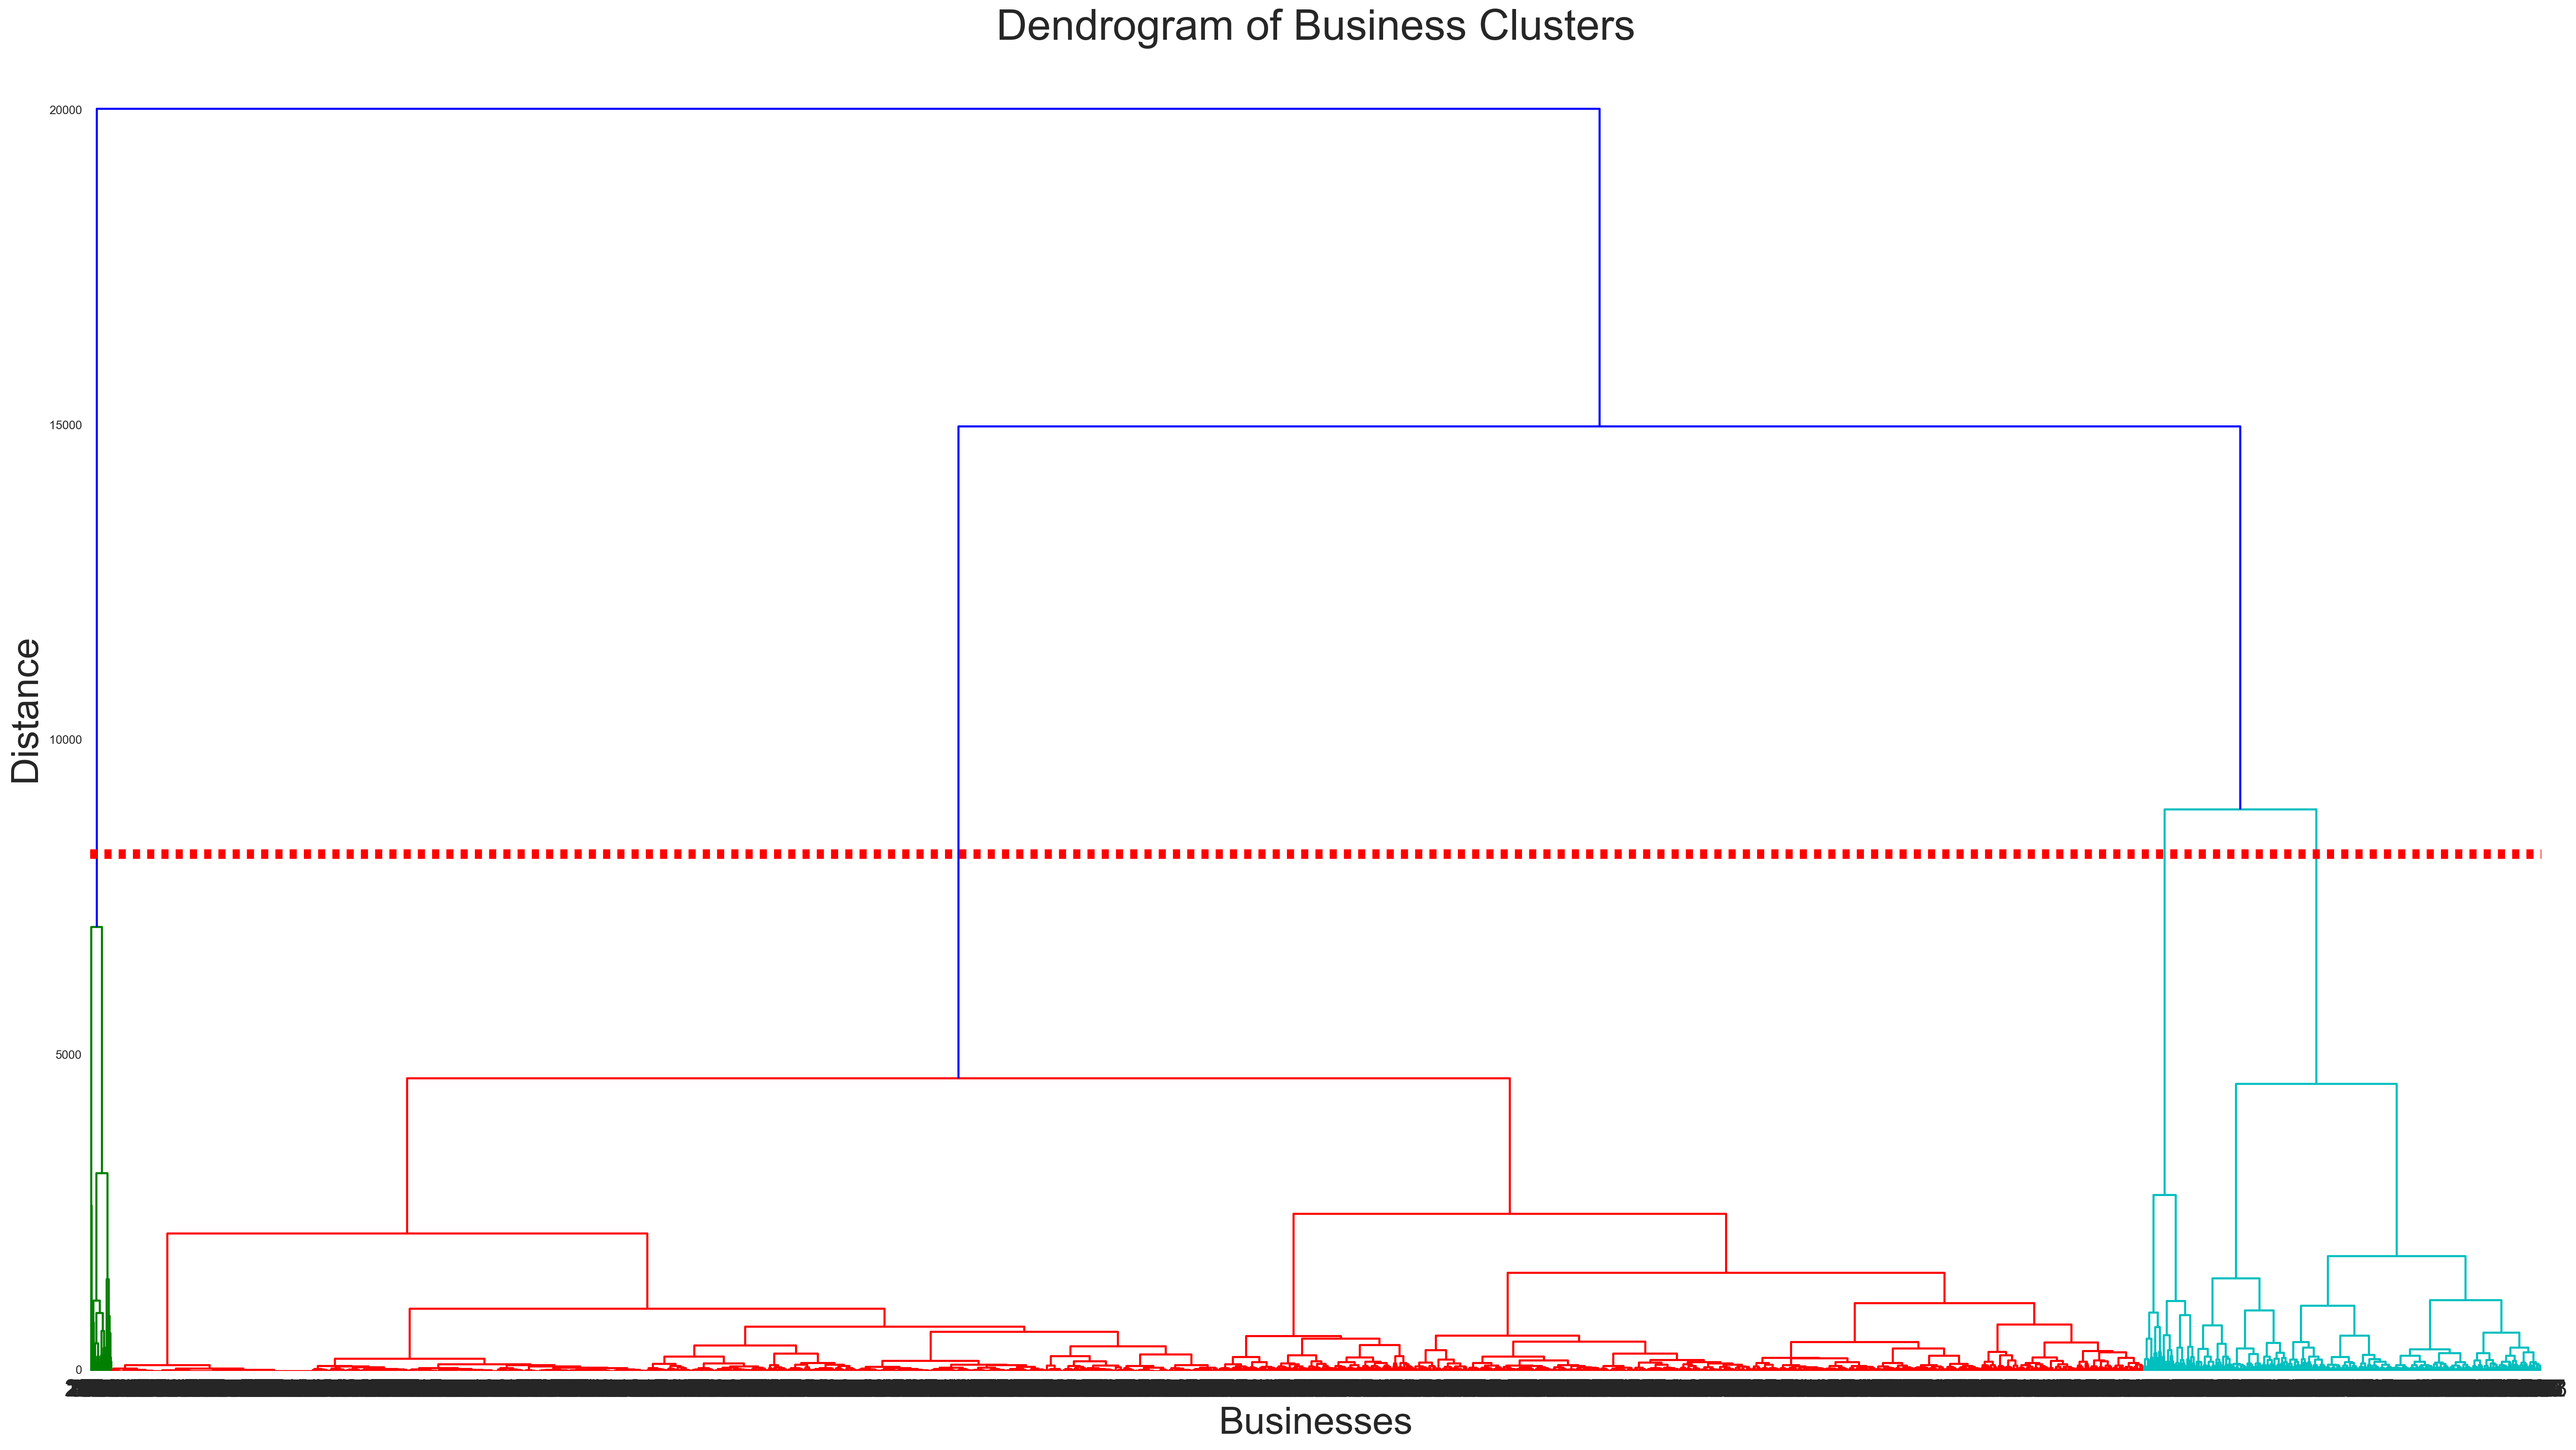

In [24]:
#perform hierarchical clustering and plot a dendogram
def plot_dendrogram(dm_new, max_dist):
    
    # Data prep, hierarchical clustering
    X = dm_new
    Z = linkage(X, 'ward')
    
    # plotting
    plt.figure(figsize = (37,20))
    
    #create max_distance line
    t = (0, max_dist)
    plt.plot((0, 86013), (max_dist, max_dist), 'r--', linewidth = 8)
    
    plt.title('Dendrogram of Business Clusters', fontdict = {'fontsize': 36})
    plt.xlabel('Businesses', fontdict = {'fontsize': 32})
    plt.ylabel('Distance', fontdict = {'fontsize': 32})
    dendrogram(
        Z,
        leaf_rotation=0.,  
        leaf_font_size=20.,
    )
    
    plt.show()
    
    
plot_dendrogram(review_count_dtw, 8200)

It seems that there are 3 main clusters in our dataset: green, red, and light blue. However, it may be worth exploring the 2 separate light-blue clusters given the high distance that they merged at. For this reason, we will look at **4 main clusters**.

---
## Add Cluster Number to Business Dataframe

In [25]:
def cluster_numbers_to_df(df, dtw_arr, max_dis, cluster_column):
    
    #create an array of our clusters that have a distance less than max_dist
    max_dist = max_dis
    X = dtw_arr
    Z = linkage(X, 'ward')
    clusters = fcluster(Z, max_dist, criterion='distance')

    #zip together business_ids and their cluster number
    business_and_clusters = zip(df.business_id.unique(), clusters)

    #create a df of the cluster number and business_id
    cluster_df = pd.DataFrame(data = business_and_clusters, columns = ['business_id', cluster_column])

    #merge cluster number onto cleveland_businesses df on business_id
    df = pd.merge(df, cluster_df, on = ['business_id'])
    
    return df

In [26]:
cleveland_businesses = cluster_numbers_to_df(cleveland_businesses, review_count_dtw, 8200, 'review_count_cluster')

In [27]:
cleveland_businesses.head()

,business_id,name,state,city,year,month,review_count,categories,review_count_cluster
0,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2014,11,2,"[u'Restaurants', u'Nightlife', u'Sports Bars',...",2
1,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2014,12,2,"[u'Restaurants', u'Nightlife', u'Sports Bars',...",2
2,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2015,1,3,"[u'Restaurants', u'Nightlife', u'Sports Bars',...",2
3,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2015,2,2,"[u'Restaurants', u'Nightlife', u'Sports Bars',...",2
4,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,OH,Cleveland,2015,3,1,"[u'Restaurants', u'Nightlife', u'Sports Bars',...",2


---
### Separate Clusters into their own respective dataframes & plot

Let's analyze each of our clusters to find what is unique about each one

In [28]:
#create sub dfs of each of our clusters
cluster_one = cleveland_businesses[cleveland_businesses.review_count_cluster == 1]
cluster_two = cleveland_businesses[cleveland_businesses.review_count_cluster == 2]
cluster_three = cleveland_businesses[cleveland_businesses.review_count_cluster == 3]
cluster_four = cleveland_businesses[cleveland_businesses.review_count_cluster == 4]

In [29]:
#number of businesses in each cluster
print cluster_one.business_id.nunique(), cluster_two.business_id.nunique(), cluster_three.business_id.nunique(), cluster_four.business_id.nunique()

33 3182 80 543


In [30]:
#create a datetime column for plotting purposes
cluster_one['date'] = cluster_one[['year','month']].apply(lambda x : '{}-{}-01'.format(x[0],x[1]), axis=1)
cluster_one.date = pd.to_datetime(cluster_one.date)

cluster_two['date'] = cluster_two[['year','month']].apply(lambda x : '{}-{}-01'.format(x[0],x[1]), axis=1)
cluster_two.date = pd.to_datetime(cluster_two.date)

cluster_three['date'] = cluster_three[['year','month']].apply(lambda x : '{}-{}-01'.format(x[0],x[1]), axis=1)
cluster_three.date = pd.to_datetime(cluster_three.date)

cluster_four['date'] = cluster_four[['year','month']].apply(lambda x : '{}-{}-01'.format(x[0],x[1]), axis=1)
cluster_four.date = pd.to_datetime(cluster_four.date)

/Users/DanielCervoni/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/DanielCervoni/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/DanielCervoni/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

(0, 3300)

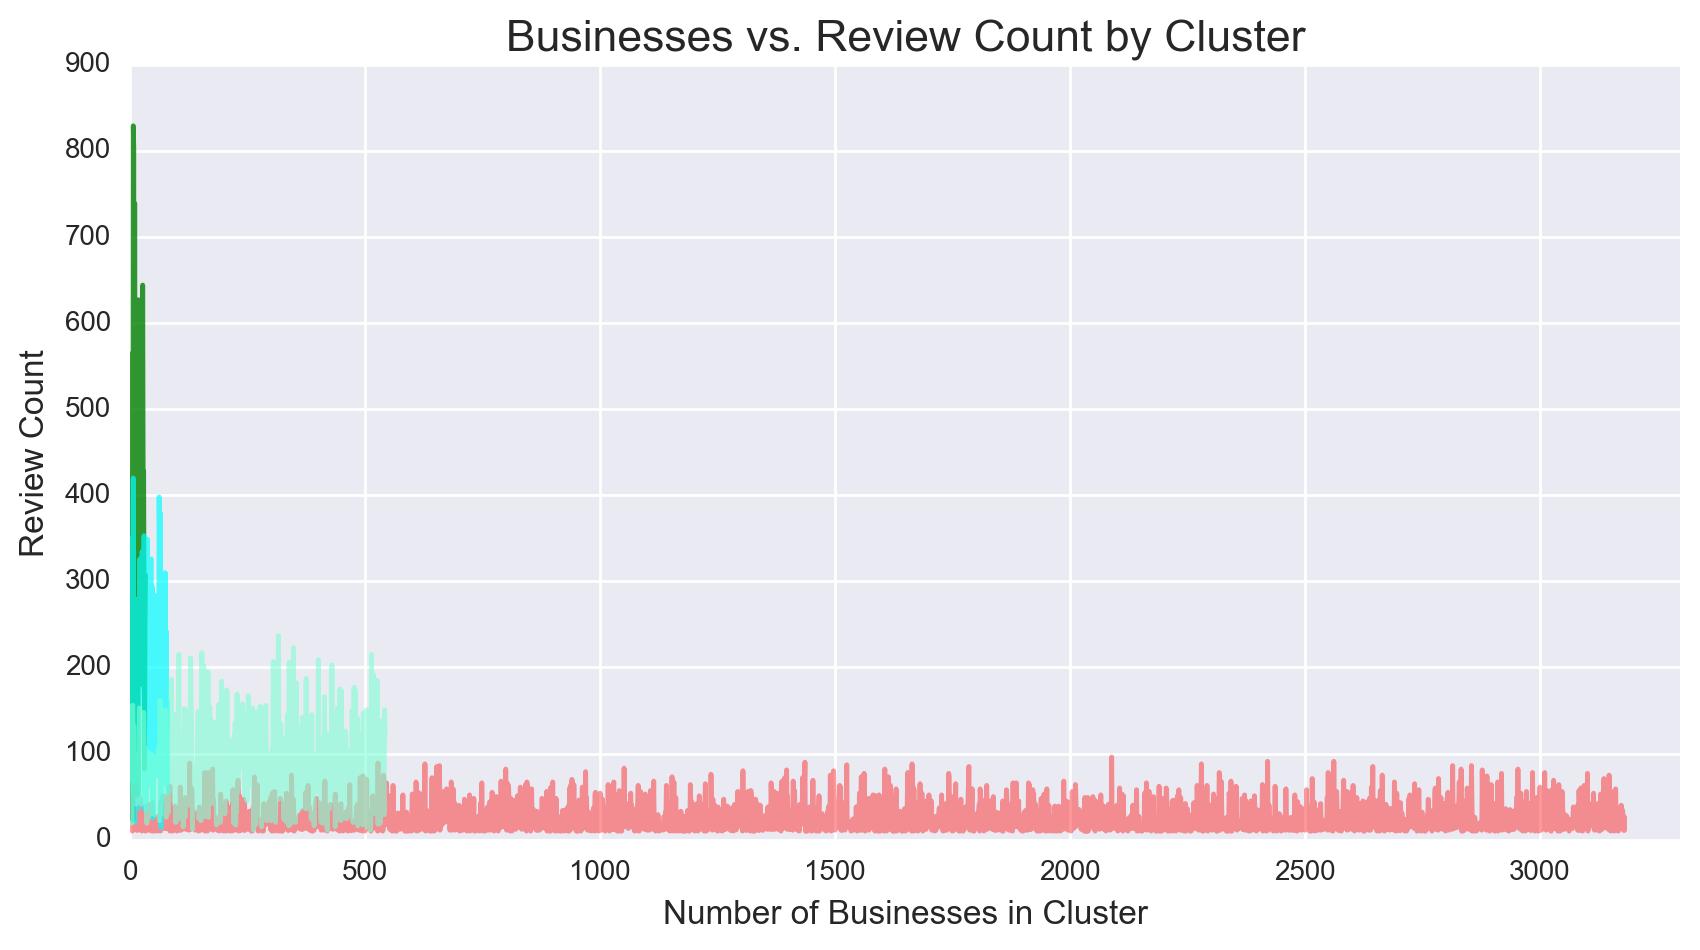

In [31]:
#plot together to see how they differ
plt.figure(figsize = (10, 5))
plt.plot(cluster_one.groupby('business_id')['review_count'].sum().values, alpha = .8, color = 'g')
plt.plot(cluster_two.groupby('business_id')['review_count'].sum().values, alpha = .4, color = 'r')
plt.plot(cluster_three.groupby('business_id')['review_count'].sum().values, alpha = .7, color = 'aqua')
plt.plot(cluster_four.groupby('business_id')['review_count'].sum().values, alpha = .6, color = 'aquamarine')
plt.xlabel("Number of Businesses in Cluster", fontdict = {'fontsize': 12})
plt.ylabel("Review Count", fontdict = {'fontsize': 12})
plt.title("Businesses vs. Review Count by Cluster", fontdict = {'fontsize': 16})
plt.xlim(0, 3300)

Our clusters have essentially been separated by review counts for businesses. Thus, we could consider the following clusters as such:

- Cluster One (Green): Businesses **very likely** to be trending
- Cluster Two (Red): Businesses **very unlikely** to be trending
- Cluster Three (Light Blue): Businesses **likely** to be trending
- Cluster Four (Teal): Businesses **unlikely** to be trending

Let's now do some plotting to see what the time-series in each of our clusters really look like. 

---
## Plotting & Analyzing Time-Series 

We now have our clusters and their respective time-series. We now need to identify a unique threshold to classify a business as trending or not. **I hypothesize that those businesses in Clusters One & Cluster Three will be our trending businesses, and those in Cluster Two & Cluster Four won't.** Therefore, let's plot multiple time-series from each and try to find what makes Cluster One & Three different from Cluster Two & Four.

Note: for the sake keeping this notebook clean, I only plotted the first 5 time-series from each cluster as an illustration. In reality, I analyzed many, many more time-series plots from each cluster to define a threshold.

In [32]:
#take the first 5 businesses in each cluster and plot them
cluster_one_five = cluster_one[cluster_one.business_id.isin(cluster_one.business_id.unique()[0:5])]
cluster_two_five = cluster_two[cluster_two.business_id.isin(cluster_two.business_id.unique()[0:5])]
cluster_three_five = cluster_three[cluster_three.business_id.isin(cluster_three.business_id.unique()[0:5])]
cluster_four_five = cluster_four[cluster_four.business_id.isin(cluster_four.business_id.unique()[0:5])]

In [33]:
#plot time series from each cluster
def plot_time_series(df, review_column):

    unique_ids = df.name.unique().tolist()
    n_plots = len(unique_ids)
    
    for idx, name in enumerate(unique_ids):

        #cle_df is a subset of that DF with all months for one business
        cle_bf = df.loc[df.name == name][['date', review_column]]

        #large figsize to cover all plots (5 in my case)
        fig = plt.figure(figsize = (8, 12))

        #create subplot for individual business
        plt.subplot(n_plots,1,idx+1)

        #plot review_count
        plt.plot(cle_bf.date, cle_bf[review_column])
        plt.title("Review Count of {} Over Time".format(name), fontdict = {'fontsize': 16})
        plt.ylabel("Review Count", fontdict = {'fontsize': 12})
        plt.ylim(0, 14)
        plt.xlabel("Time", fontdict = {'fontsize': 12})
        plt.show()

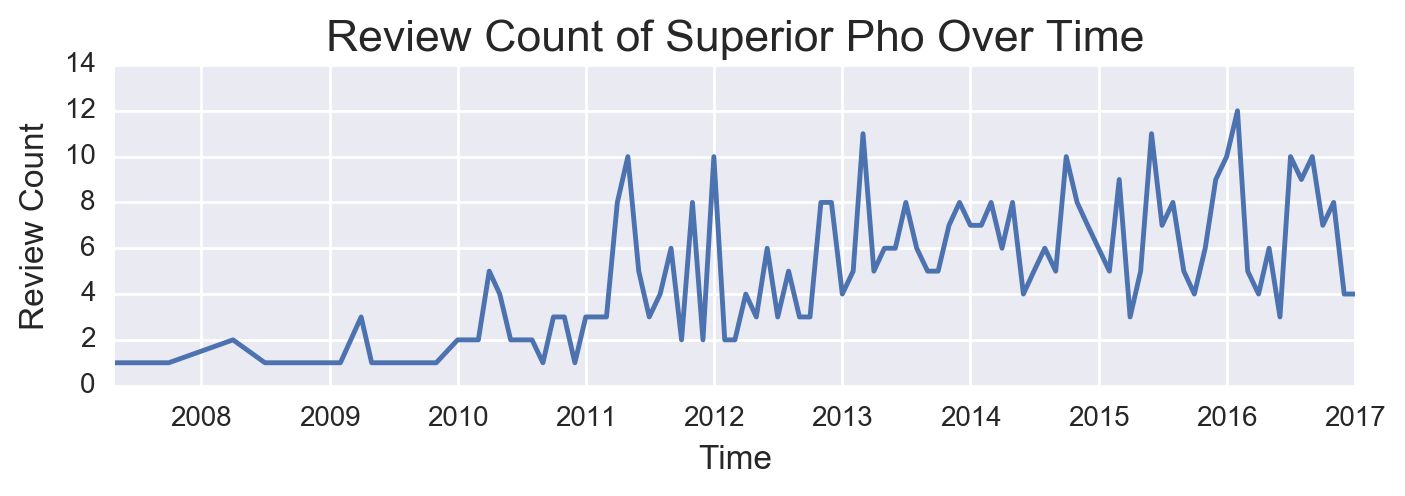

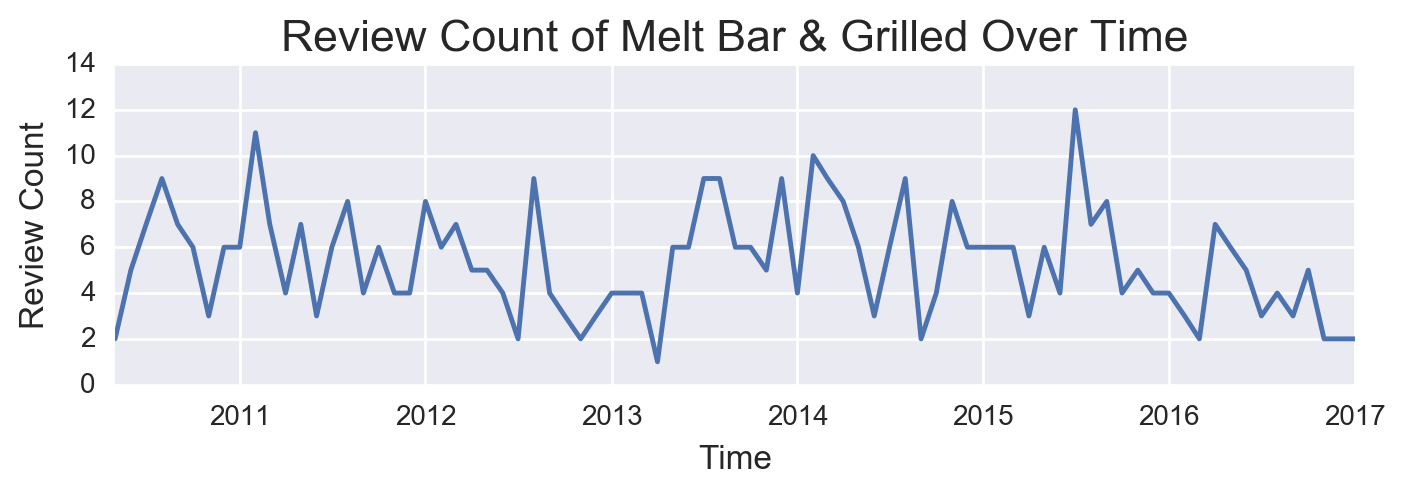

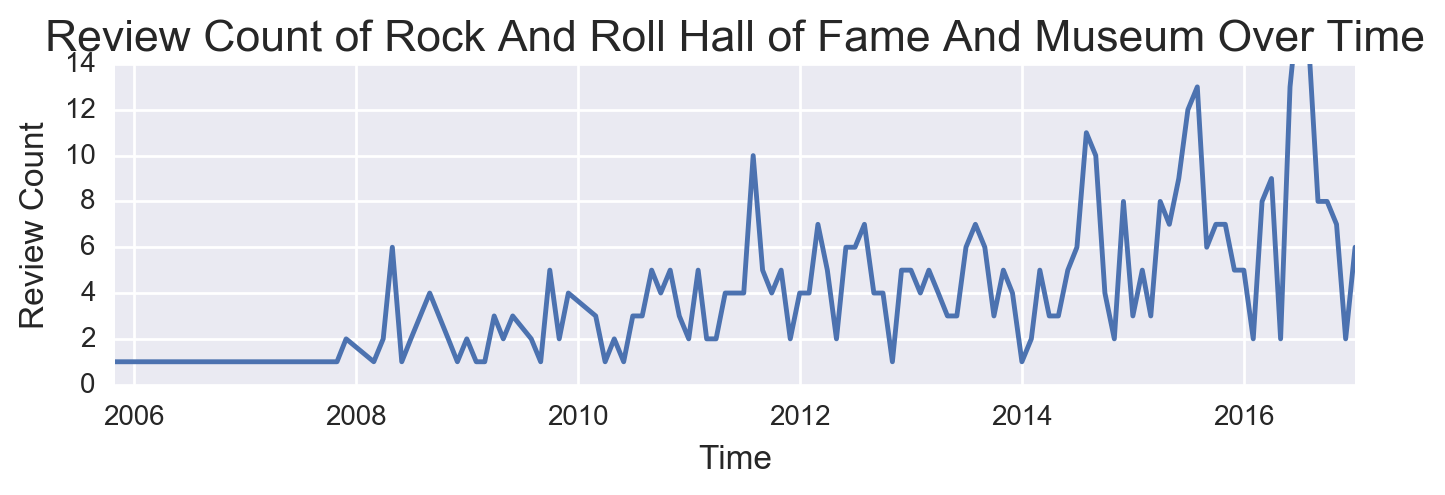

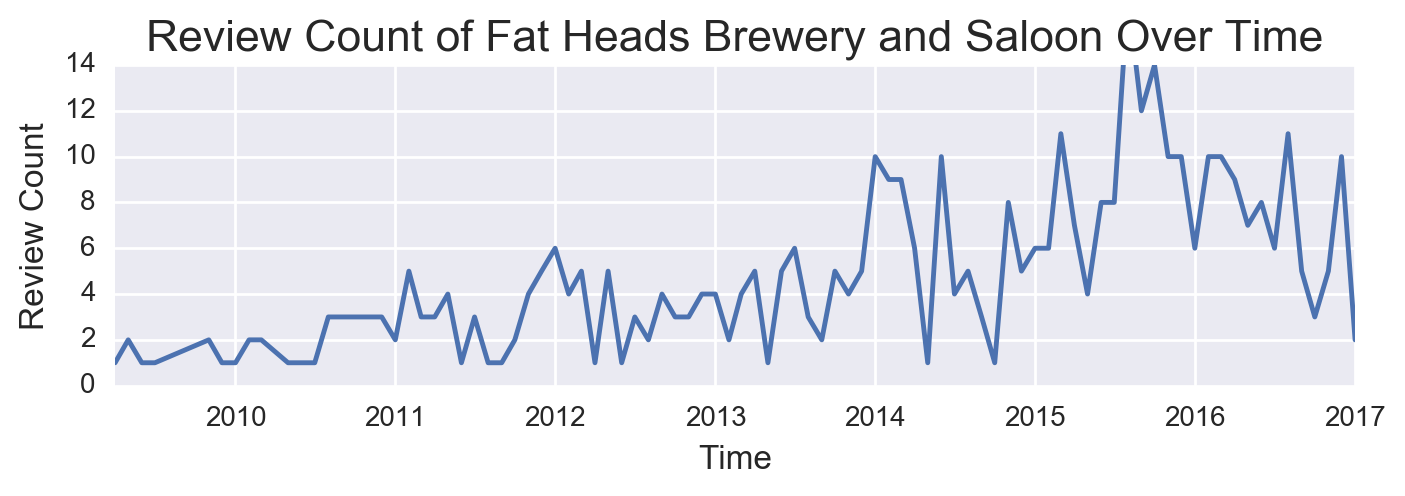

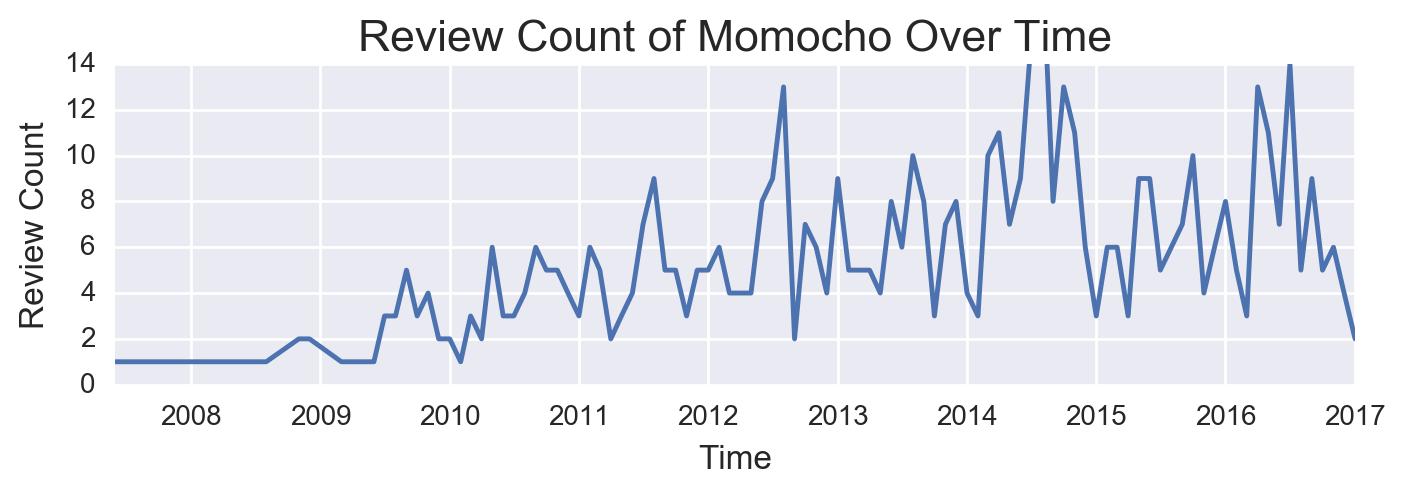

In [34]:
plot_time_series(cluster_one_five, 'review_count')

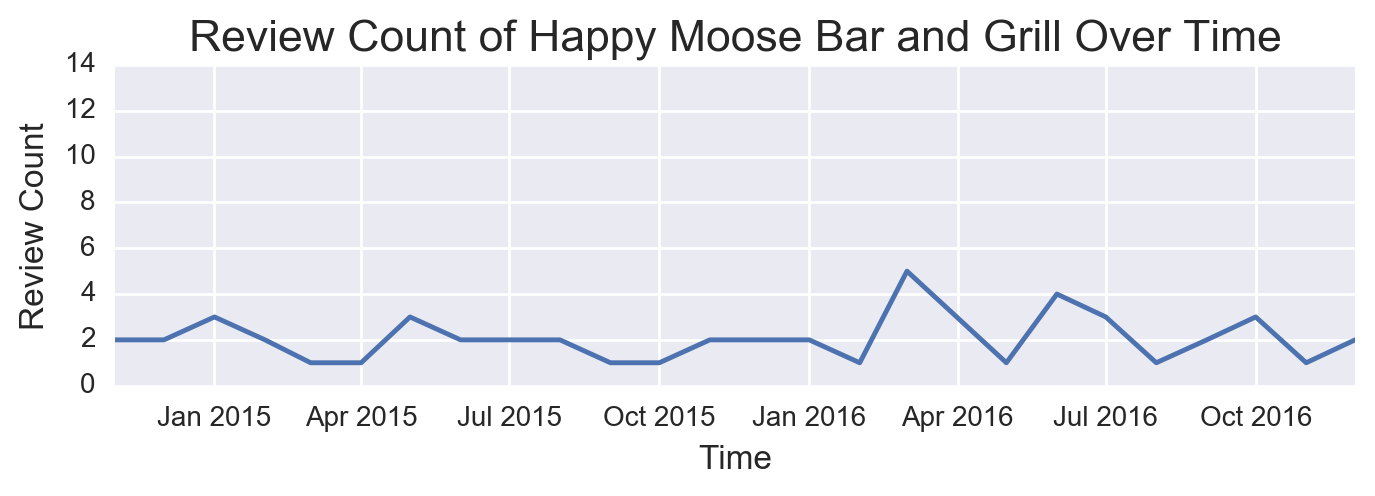

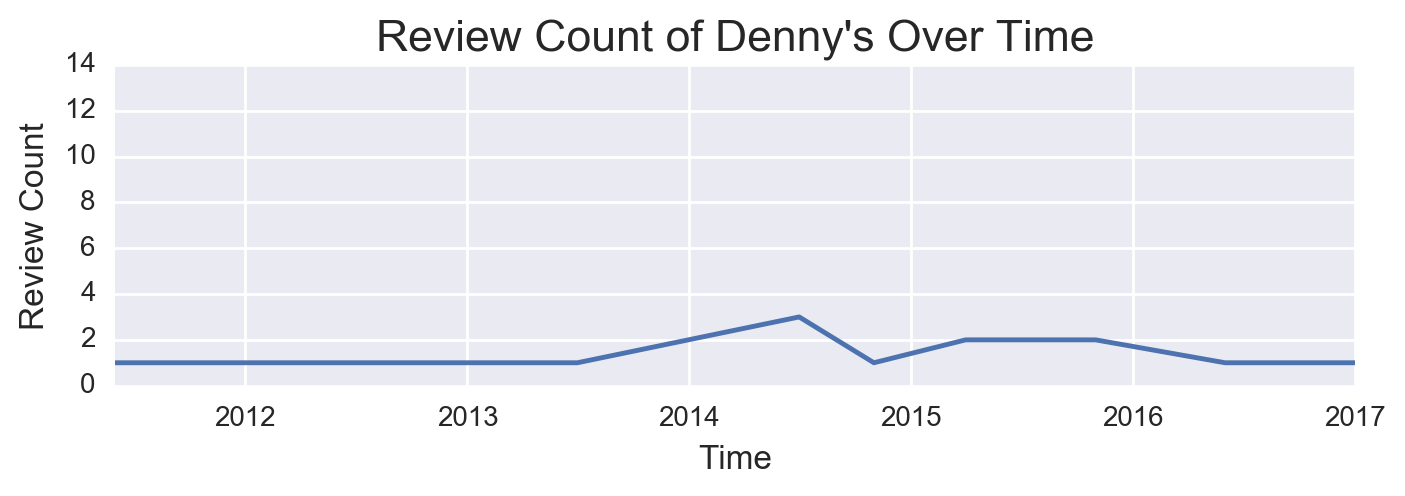

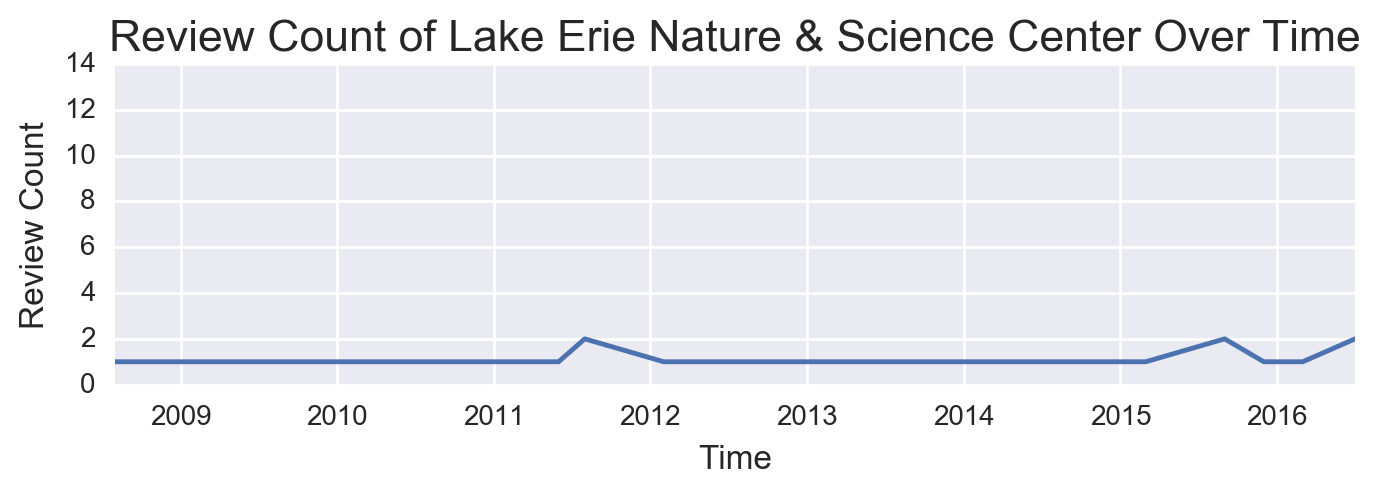

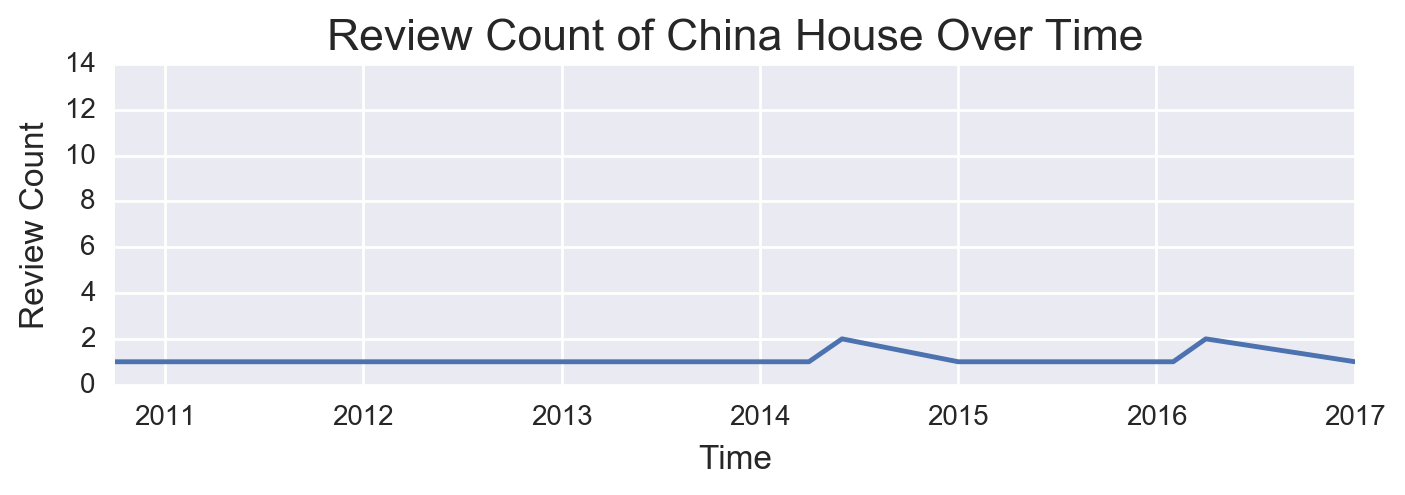

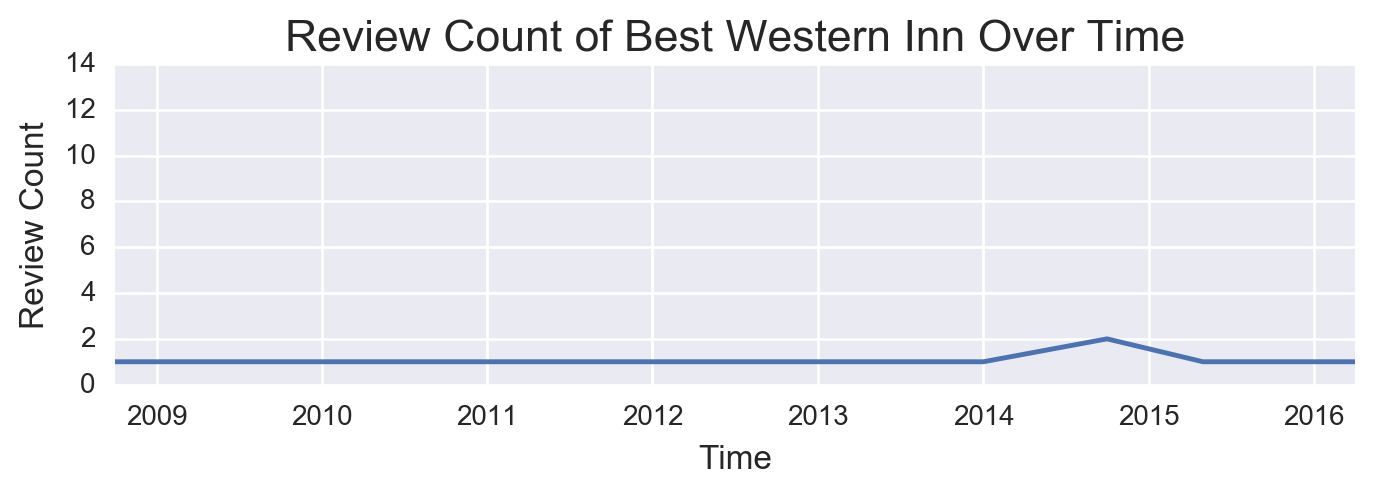

In [35]:
plot_time_series(cluster_two_five, 'review_count')

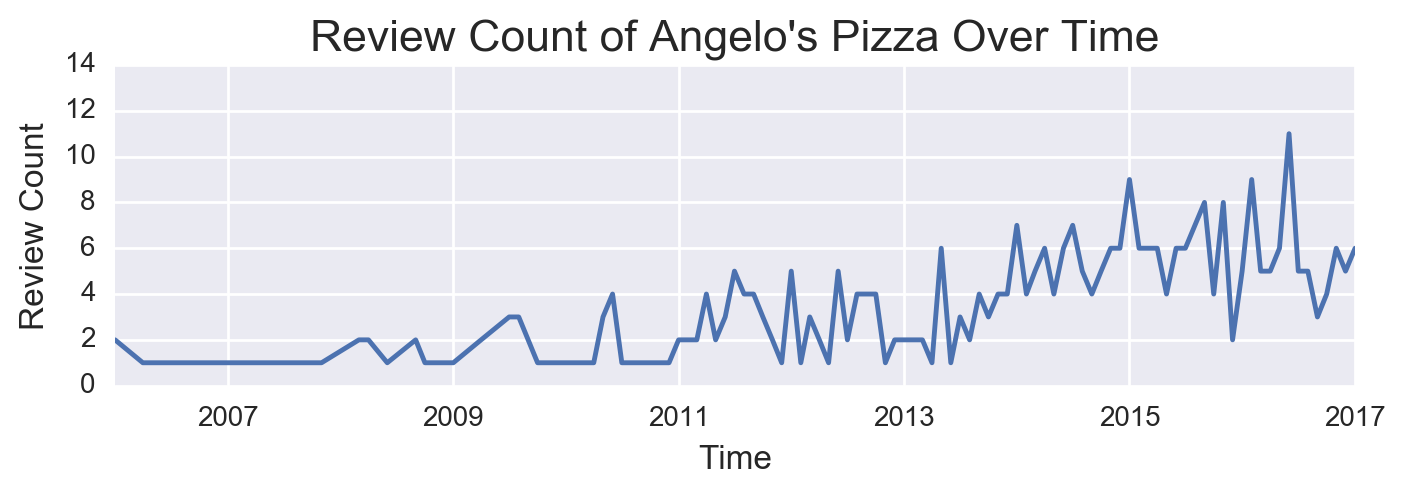

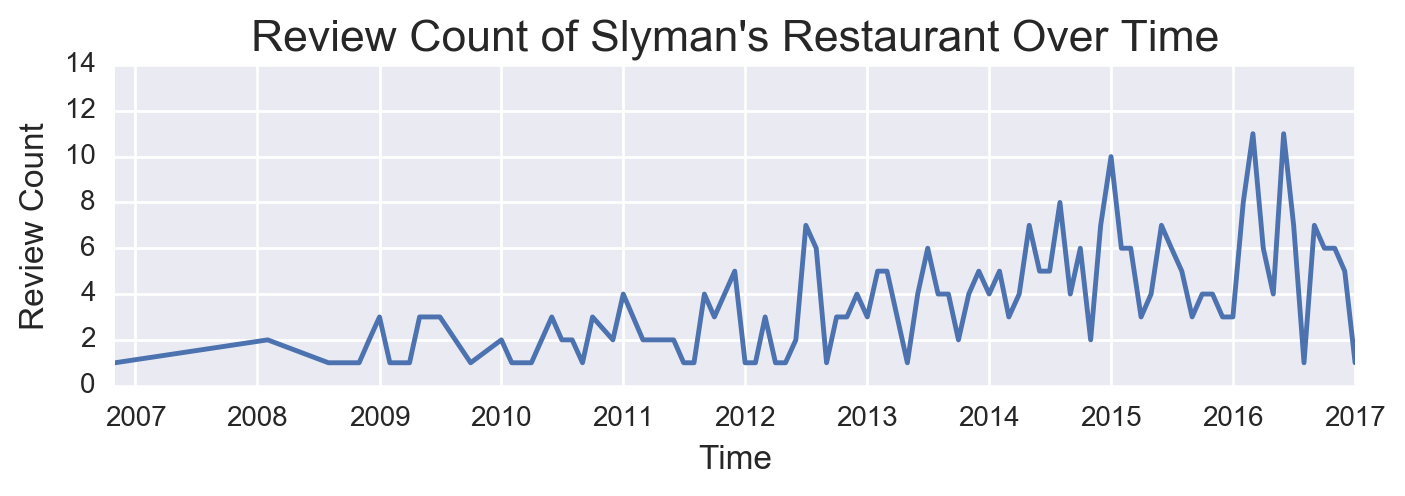

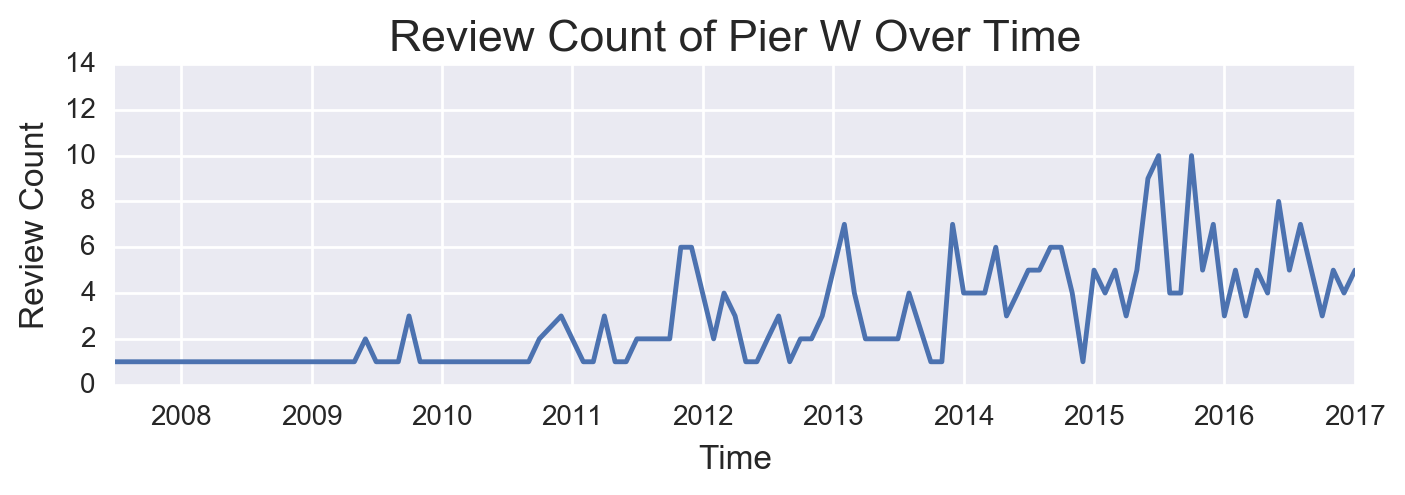

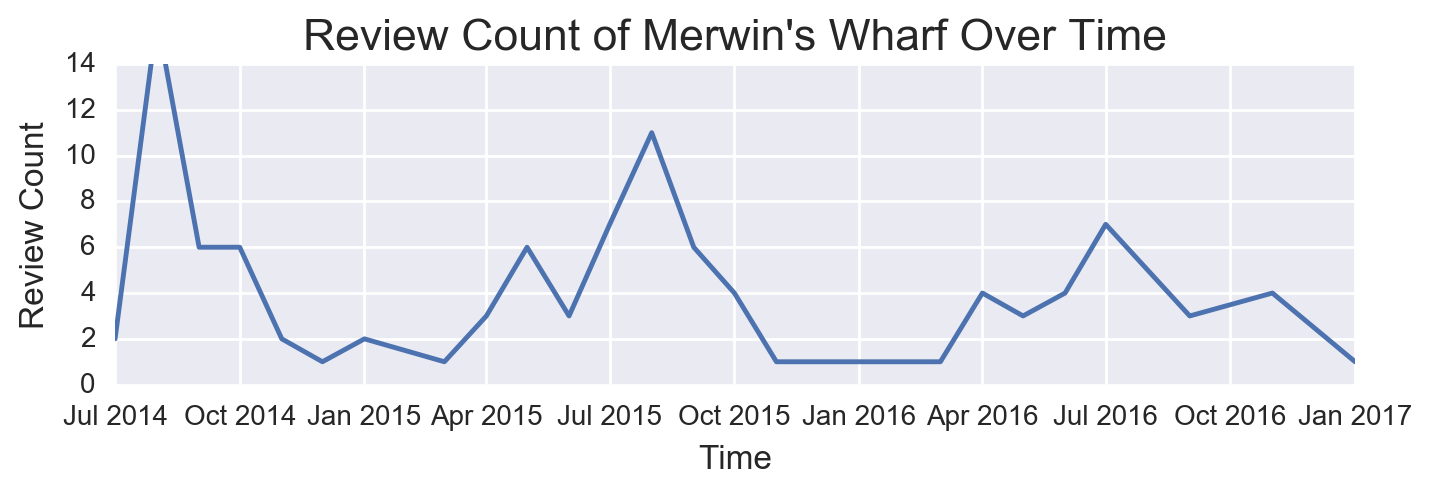

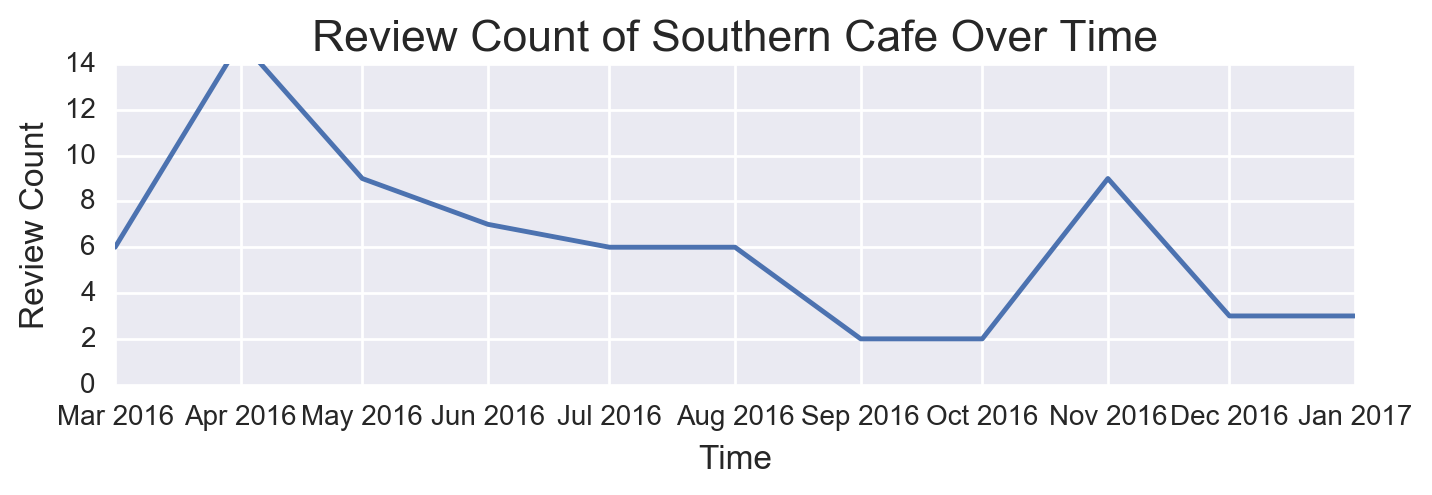

In [36]:
plot_time_series(cluster_three_five, 'review_count')

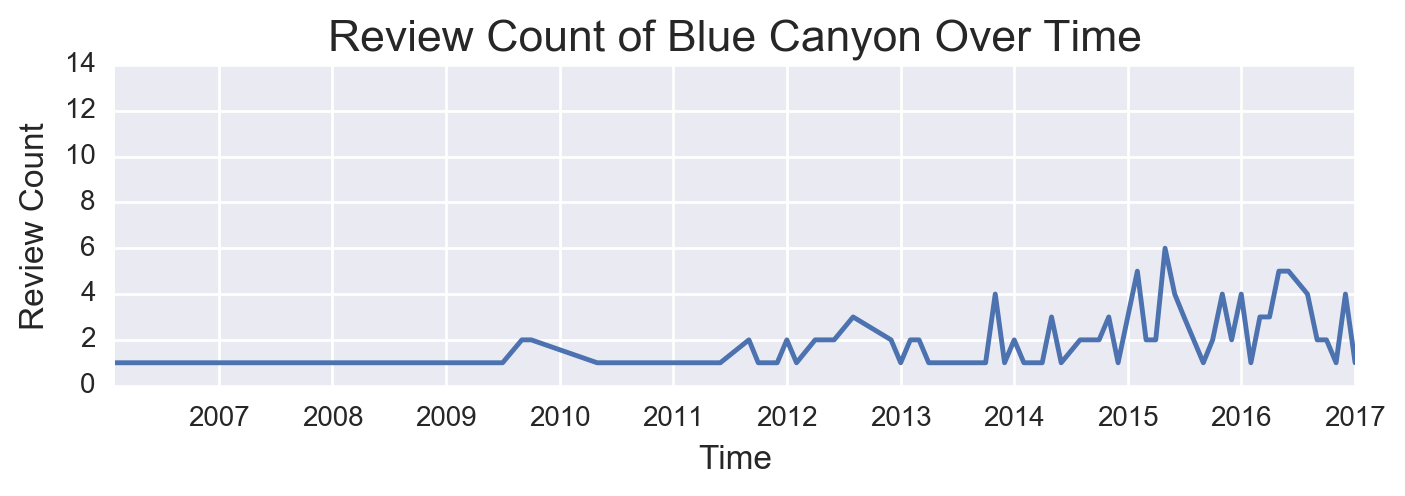

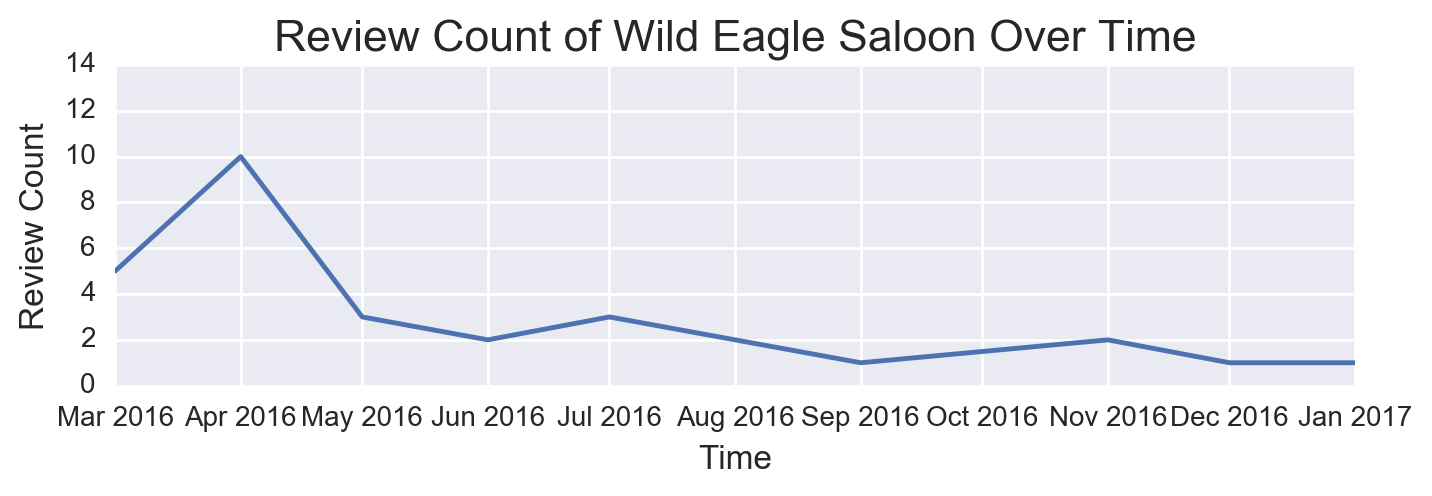

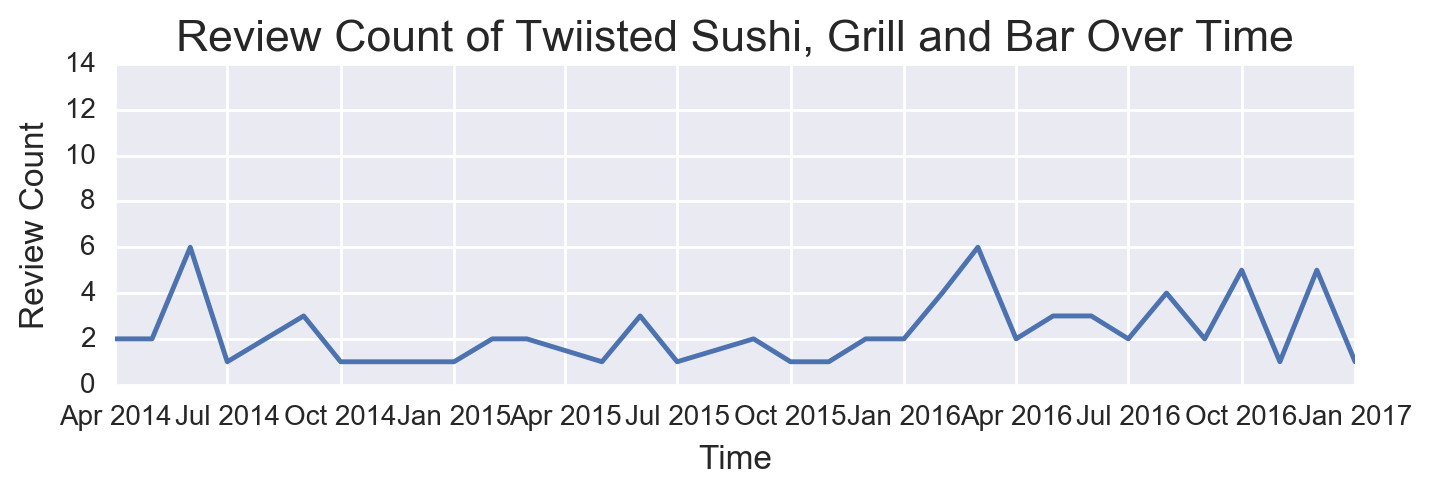

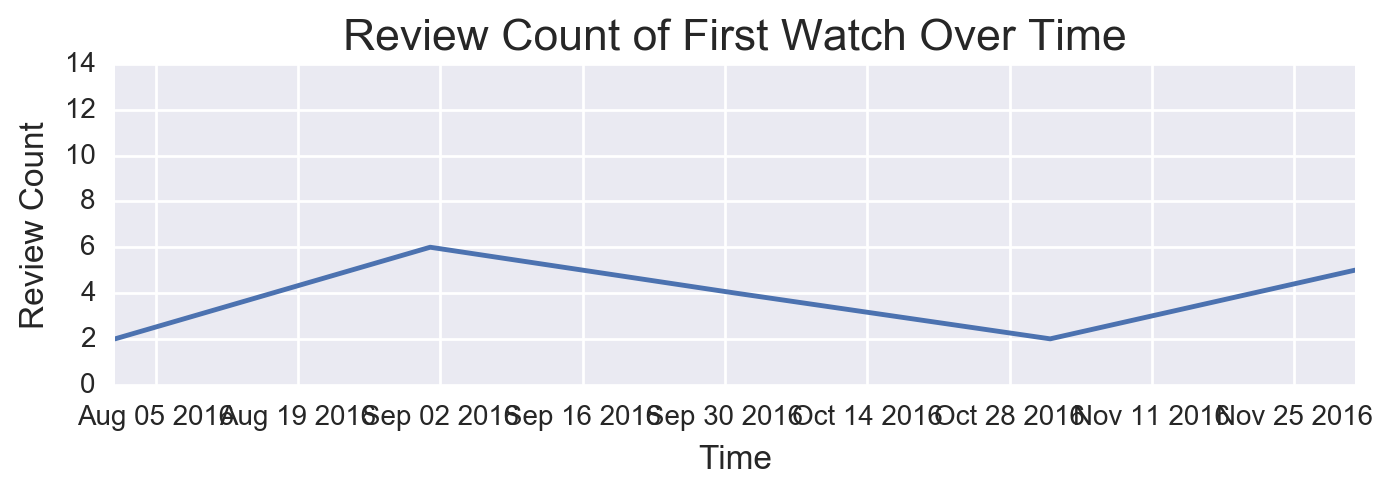

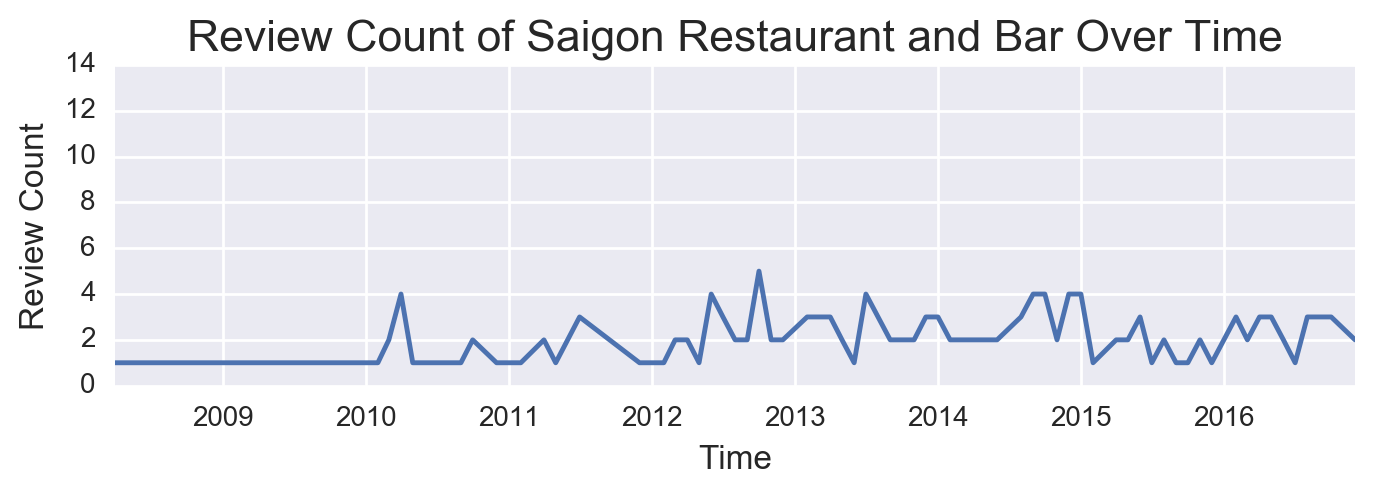

In [37]:
plot_time_series(cluster_four_five, 'review_count')

After analyzing our time-series, one thing that seems to be unique about businesses in Cluster One & Three is that they seem to reach at least 2 consecutive months of 6-8 monthly reviews. 

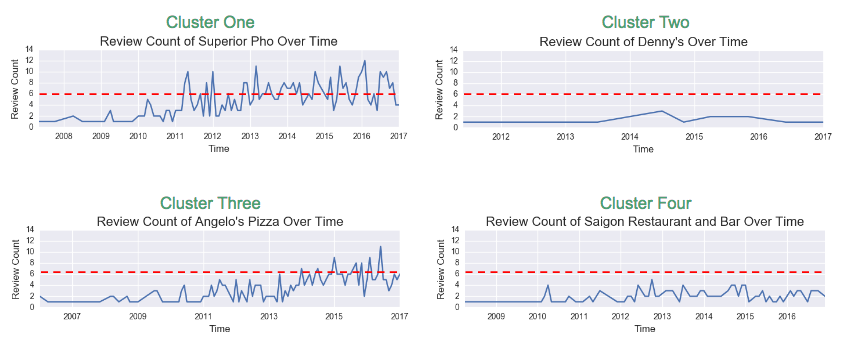

In [38]:
Image(filename = "/Users/DanielCervoni/Desktop/time-series.png")

To sanity check this as a possible definition, we can compare the number of businesses that meet this threshold versus the number of businesses in Cluster One + Cluster Three (113). After filtering for this condition in my PostgreSQL database of Cleveland businesses, there are 136 businesses that have 2 consecutive months with at least 7 monthly reviews (Note: 3 businesses had less than 3 months of data, so I excluded them). Here is the breakdown by cluster:

- **Cluster One**: 97% of businesses
- **Cluster Two**: 0% of businesses
- **Cluster Three**: 73.75% of businesses
- **Cluster Four**: 8.28% of businesses

Because 136 is similar to 113, and because the condition includes almost all businesses in Cluster One & Cluster Three, **I can conclude that this definition serves as a strong classifier for classifying a business as 'trendy' or not.**

Now we can begin to perform Network Analysis to identify our most 'trendy' users & their levels of influence. See Network Analysis Notebook.